# Algorithme génétique pour le problème du max-one

*nicolas.bredeche(at)upmc.fr*

Mise à jour: 
* 2017-03-20 - première version (avec A. Pajot et P. Ecoffet)
* 2018-03-29 - ajout d'une représentation graphique, découpage en cellule
* 2020-12-06 - passage en Python 3.x
* 2020-12-10 - révision majeure MU4RBI04
* 2021-11-19 - modification de la question 4

<!--`print()`-->

---

Ce notebook décrit un algorithme génétique basique, qui est illustré sur le problème classique du *max-one*. 

La première partie définit les fonctions utiles pour l'algorithme, et se conclut par une cellule contenant un "**Exemple introductif**" qui montre comment l'utiliser. 

La seconde partie contient les questions à répondre. Il s'agit dans un premier temps d'utiliser l'algorithme définit auparavant en changeant ses paramètres. Dans un second temps, vous devrez ajouter des opérateurs (de sélection, de variation). Enfin, il s'agira d'aborder un nouveau problème, qui demande de réflechir à la structure du génome et sa conséquence sur les opérateurs. 

Pour finir, on abordera un problème important des algorithmes évolutionnaire: la stochasticité, qui implique de faire plusieurs exécutions indépendantes et d'en compiler les résultats pour avoir une bonne estimation en moyenne de la performance de nos algorithmes.

---

# Initialisation et défitions de fonctions d'affichage

Remarque: *il n'est pas nécessaire d'étudier le code de cette partie (importation des librairies et définition de fonction pour l'affichage)*

In [50]:
#%matplotlib inline
#%load_ext Cython

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


import operator
import copy

import os
from datetime import datetime
from datetime import date

from random import random, randint, sample

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:53:50 GMT
OK.


In [51]:
# Graph-related functions

def plot(x,y,xMin,xMax,yMin,yMax):
    colors = "red" #np.random.rand(len(x))
    area = np.pi * (5 * np.ones(1))**2
    plt.xlim(xMin, xMax)
    plt.ylim(yMin, yMax)
    plt.scatter( np.asarray(x), np.asarray(y), s=area, c=colors, alpha=0.5)
    plt.show()
    
def plotIndividuals(datapop,xMin=0,xMax=1,yMin=0,yMax=1):
    xCoord = []
    yCoord = []
    
    for e in datapop:
        xCoord.append(e[0])
        yCoord.append(e[1])
    
    plot(xCoord,yCoord,xMin,xMax,yMin,yMax)

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:53:50 GMT
OK.


---

# Algorithme génétique : fonction objectif pour le problème du *max-one*

Nous définissons ici le **problème du max-one**, pour lequel le score (=la fitness) est d'autant plus élevé que le nombre de bits dans le génome vaut 1. 

**Données du problème**
* **représentation**: le génome d'un individu est défini comme une suite finie de 0 et de 1 (i.e. *n* valeurs binaires)
* **objectif**: la solution optimale est atteinte lorsque le génome d'un individu est uniquement constitué de 1
* **calcul de la fitness**: distance de Hamming entre la solution candidate et la solution optimale (ici: l'objectif est artificiellement fixé comme une suite de 1)

Il s'agit là d'un problème *jouet* très utilisé pour étudier la dynamique de l'optimisation.


In [52]:

# renvoie la fitness d'un individu pour le problème max-one
def evaluate_oneMaxProblem(genome):
    fitness = 0
    for e in genome:
        if e == 1:
            fitness = fitness + 1
    return fitness

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:53:50 GMT
OK.


# Algorithme génétique : opérateurs


On suivra la convention suivante pour les structures de données: 
*   un *individu* est un tableau qui comprend dans sa première case un *génome* (ici: une suite de valeurs binaires) et dans sa seconde case une *fitness* (c'est à dire son score, à calculer en fonction du problème à résoudre).
*   une *population* est une liste qui contient des *individus*

On définit dans la cellule qui suit:

*   un opérateur de mutation (bitflip mutation)
*   un opérateur de sélection (tournament selection, de taille *k*)
*   une fonction qui renvoie le meilleur individu d'une population


In [53]:
# renvoie une copie mutée de l'individu passé en paramètre, selon la méthode de mutation "bit-flip"
def mutateBitFlip(individu,pMutation):
    nouvelIndividu = []
    for e in individu:
        if random() < pMutation:
            nouvelIndividu.append( (e + 1) % 2 )
        else:
            nouvelIndividu.append( e )
    return nouvelIndividu

# renvoie un individu sélectionné selon méthode du tournoi (de taille k)
def selectTournament(pop,k):
    # sélectionne K individus (au hasard) pour le tournoi
    tournoi = sample(list(range(len(pop))),k) # renvoi les index de K individus parmis N
    # sélectionne le meilleur parmis les K individus (classe par ordre croissant, renvoi le dernier élément selon le fitness)
    parent = pop[ sorted(tournoi, key=lambda x:pop[x][1])[-1] ][0]
    return parent

# renvoie le meilleu individu de la population passée en paramètre
def returnBestIndividual(pop):
    meilleureFitness = 0
    meilleurGenome = []
    for individu in pop:
        if individu[1] > meilleureFitness:
            meilleureFitness = individu[1]
            meilleurGenome = individu[0]
    return [meilleurGenome,meilleureFitness]

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:53:51 GMT
OK.


# Algorithme génétique: boucle d'évolution (fonction principale)

La fonction *evolve* décrit la boucle principale de l'algorithme génétique. Elle est générique, dans le sens ou on doit lui fournir l'opérateur de sélection de parent, l'opérateur de mutation et l'opérateur d'évaluation. 

Etudiez son fonctionnement. Nous l'utiliserons dans la cellule suivante.

Remarque: la variable *verbose* permet d'afficher plus (si True) ou moins (si False) de détails. *italicized text*

In [54]:
#
# Boucle principale de l'algorithme génétique
#

def evolve(pop,evals,taillePop,evaluate,select,mutate,pMutation,verbose=False):
  it = 0
  nbGen = 0
  data = []

  meilleurIndividuDepuisToujours = [[],0]

  while it + taillePop <= evals:

      if verbose == True:
          print ("# Generation", nbGen,":",)

      # évalue les individus

      for individu in pop:
          individu[1] = evaluate(individu[0])

      # mémorise le meilleur de la génération
      meilleurIndividu = returnBestIndividual(pop)
      data.append([it+taillePop,meilleurIndividu[1]])

      # met à jour, si nécessaire, le meilleur individu depuis le début
      if meilleurIndividu[1] > meilleurIndividuDepuisToujours[1]:
        meilleurIndividuDepuisToujours = meilleurIndividu[:]
        meilleurIteration = it # donne l'itération correspondant au début de la génération courante.

      if verbose == True:
        print ("\tMeilleur individu courant:",meilleurIndividu[0]," -- fitness:",meilleurIndividu[1])

      # construit une nouvelle population

      nouvellePopulation = []

      for i in range(taillePop):

          parent = select(pop,tailleTournoi)

          # crée un nouvel individu par mutation de l'individu parent, et ajoute à la nouvelle population
          nouvelIndividu = mutate(parent,pMutation)

          #print ("\tParent:", parent)
          #print ("\tchild :",nouvelIndividu) 

          nouvellePopulation.append([nouvelIndividu,0])

      # passe a la génération suivante

      pop = nouvellePopulation[:]

      it = it + taillePop
      nbGen += 1

  return (data,meilleurIndividuDepuisToujours,meilleurIteration)

print(date.today(), datetime.now().strftime("%H:%M:%S"),"GMT") # timestamp is greenwich time
print("OK.")

2021-11-25 15:53:51 GMT
OK.


# Exemple introductif: optimisation sur le problème max-one

Nous allons utiliser un algorithme génétique simple pour résoudre le problème du max-one.

L'algorithme génétique que nous utilisons est défini comme suit:

* **représentation**: le *génome* d'un individu est représenté par une suite de bits (0 ou 1). 
* **opérateurs**: nous utilisons une sélection par tournoi et un seul opérateur de variation: la mutation "bit-flip" vue en cours.



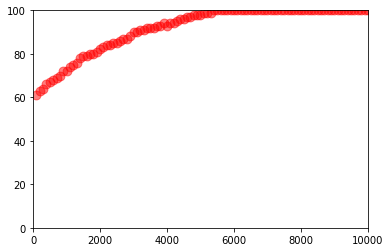

Meilleure genome     : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Meilleure fitness    : 100
trouvé à l'itération : 5300


In [55]:
# paramètres 

evaluations = 10000
tailleInd = 100
taillePop = 100
tailleTournoi = 8
Pmutation = 1./tailleInd #1.0/tailleInd
verbose = False

# test

if taillePop < tailleTournoi:
  print ("Erreur: la taille de la population ne peut pas être inférieure à la taille du tournoi.")

# initialisation des individus de la population initiale

population = []
for i in range(taillePop):
    genome = []
    for j in range(tailleInd):
        genome.append( randint(0,1) )
    population.append([genome,0]) # N * [ genome[] , fitness ]

# exécute l'algorithme génétique

retValue = evolve(population,evaluations,taillePop,evaluate_oneMaxProblem,selectTournament,mutateBitFlip,Pmutation,verbose)

# affichage des résultats 

plotIndividuals(retValue[0],0,evaluations,0,tailleInd)

print ("Meilleure genome     :", retValue[1][0])
print ("Meilleure fitness    :", retValue[1][1])
print ("trouvé à l'itération :", retValue[2])



---
---
# TRAVAUX PRATIQUES

Préambule: *vous devez répondre à cette question et aux suivantes dans les cellules qui les suivent -- **ne modifiez pas** les cellules précédentes. Vous allez réutiliser certaines fonctions définies précédemment, et vous pourrez vous inspirer du code ci-dessus pour répondre aux questions.*

Chaque exercice doit être indépendant. C'est à dire que pour chaque exercice, vous réinitialiserez les valeurs des paramètres à celle définies dans l'exemple ci-dessus, sauf si cela est explicitement demandé.

L'algorithme étant stochastique, il faut obligatoirement faire plusieurs exécutions indépendantes pour un même jeu de paramètres avant de conclure sur la performance et la vitesse de convergence moyennes. Idem avant de comparer 2 jeux de paramètres.




---



# Exercice 1

Etudiez le comportement de l'algorithme lorsque l'on change la taille de la population, pour un même nombre d'évaluations au total. 

Affichez les résultats pour trois paramètrages "typiques" (uniquement le graphe et la valeur du meilleur individu, comme ci-dessus).

Qu'en concluez-vous?


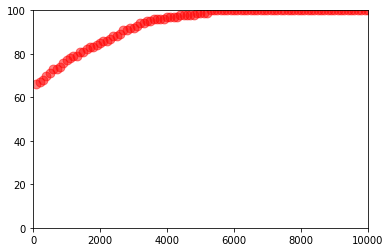

Meilleure genome     : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Meilleure fitness    : 100
trouvé à l'itération : 5200


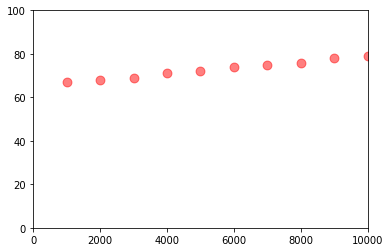

Meilleure genome     : [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]
Meilleure fitness    : 79
trouvé à l'itération : 9000


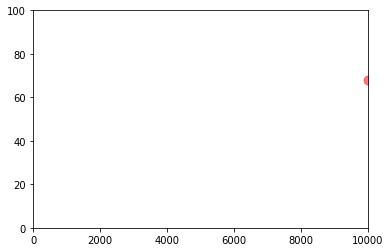

Meilleure genome     : [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Meilleure fitness    : 68
trouvé à l'itération : 0


In [56]:
# votre code

# paramètres 

evaluations = 10000
tailleInd = 100
taillesPop = [100,1000,10000]
tailleTournoi = 8
Pmutation = 1./tailleInd #1.0/tailleInd
verbose = False

# test
for taillePop in taillesPop:
  if taillePop < tailleTournoi:
    print ("Erreur: la taille de la population ne peut pas être inférieure à la taille du tournoi.")

  # initialisation des individus de la population initiale

  population = []
  for _ in range(taillePop):
    genome = [randint(0,1) for _ in range(tailleInd)]
    population.append([genome,0]) # N * [ genome[] , fitness ]

  # exécute l'algorithme génétique

  retValue = evolve(population,evaluations,taillePop,evaluate_oneMaxProblem,selectTournament,mutateBitFlip,Pmutation,verbose)

  # affichage des résultats 

  plotIndividuals(retValue[0],0,evaluations,0,tailleInd)

  print ("Meilleure genome     :", retValue[1][0])
  print ("Meilleure fitness    :", retValue[1][1])
  print ("trouvé à l'itération :", retValue[2])


*votre réponse*

On trace la performance après que la génération se soit déroulée, on observe donc à chaque fois x points, correspondant aux 1000 évaluations divisé par la taille de la population. Plus la taille de la population est grande (ou le nombre d'évaluation élevé), plus la courbe sera dense et la qualité des résultats élevée. 

Lorsque la taille de la population est trop élevée pour pas assez d'évaluations, les nouvelles populations prennent "trop de temps" à se former sur le long terme. Le caractère aléatoire des mutations (et de la sélection, significatif dans le cas d'un opérateur K-tournament) n'impacte pas assez les individus, pour converger vers le génome idéal (max-one). Au contraire, lorsque la taille de la population est faible, l'algorithme tourne plus de fois, laissant apparaitre plus de mutation bénéfiques.

D'un point de vu performance, la meilleure fitness est atteinte plus rapidement dans le temps lorsque la population est plus réduite. De plus, lorsque la taille de la population est trop élevée et/ou le temps d'étude trop réduit, la performance augmente moins vite (allure de la courbe).




---


# Exercice 2

Etudiez le comportement de l'algorithme lorsque l'on change le taux de mutation. 

Affichez les résultats pour trois paramètrages "typiques" (uniquement le graphe et la valeur du meilleur individu, comme ci-dessus).

Qu'en concluez-vous?


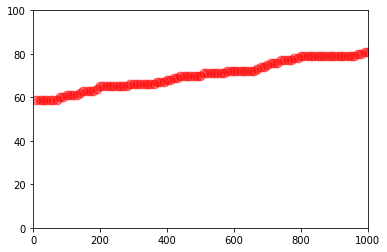

Taux de mutation : 0.001  Meilleure fitness    : 81  trouvé à l'itération : 980
Meilleure genome     : [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


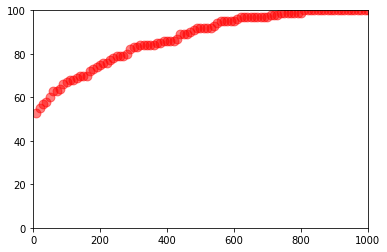

Taux de mutation : 0.01  Meilleure fitness    : 100  trouvé à l'itération : 800
Meilleure genome     : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


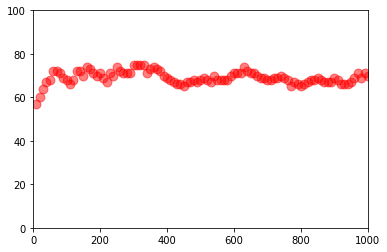

Taux de mutation : 0.1  Meilleure fitness    : 75  trouvé à l'itération : 290
Meilleure genome     : [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]


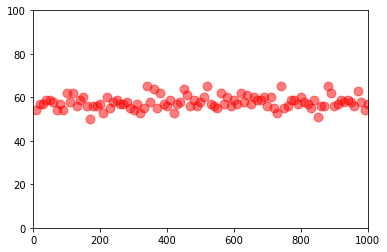

Taux de mutation : 0.5  Meilleure fitness    : 65  trouvé à l'itération : 330
Meilleure genome     : [1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]


In [59]:
# votre code


taillesPop = 10

Pmutations = [0.001, 0.01, 0.1, 0.5]


# test
for Pmutation in Pmutations:
  if taillePop < tailleTournoi:
    print ("Erreur: la taille de la population ne peut pas être inférieure à la taille du tournoi.")

  # initialisation des individus de la population initiale

  population = []
  for _ in range(taillePop):
    genome = [randint(0,1) for _ in range(tailleInd)]
    population.append([genome,0]) # N * [ genome[] , fitness ]

  # exécute l'algorithme génétique

  retValue = evolve(population,evaluations,taillePop,evaluate_oneMaxProblem,selectTournament,mutateBitFlip,Pmutation,verbose)

  # affichage des résultats 

  plotIndividuals(retValue[0],0,evaluations,0,tailleInd)
  print ("Taux de mutation :", Pmutation, " Meilleure fitness    :", retValue[1][1], " trouvé à l'itération :", retValue[2])

  print ("Meilleure genome     :", retValue[1][0])
  
  """print ("Meilleure fitness    :", retValue[1][1])
  print ("trouvé à l'itération :", retValue[2])"""


*votre réponse*

D'après les graphiques , on remarque que plus le taux de mutation est faible, plus l'évolution de la performance sera lente . Pour un tel schéma, cela signifie que les individus, dits enfants, à chaque nouvelle population seront trop identiques aux générations précédentes.

Au contraire, si la mutation est trop forte, on détruit l'action de notre opérateur de sélection (voir Fig.3-4). En effet bien que l'on sélectionne les meilleurs individus, avec un fort taux de mutation, on crée des enfants trop différents des parents, ce qui n'a plus de sens. 

En conclusion, le choix d'un taux de mutation d'environ 1% semble le plus adapté et amène une meilleure performance et le plus rapidement. 



---



---


# Exercice 3

Implémentez un opérateur de sélection (mu,lambda). Testez-le avec
* mu = taillePopulation / 2
* mu = 1

Vous devrez donc adapter l'exemple initial, et ajouter un nouvel opérateur de sélection.

Affichez les résultats pour ces deux paramètrages, ainsi que pour un troisième dont vous pouvez choisir la valeur.

Qu'en concluez-vous?


[[[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1], 56], [[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0], 51], [[1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1], 50], [[1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1

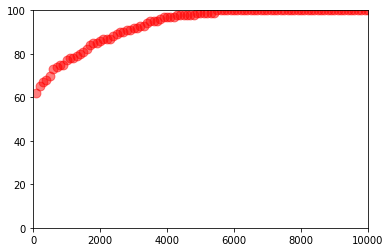

Meilleure genome     : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Meilleure fitness    : 100
trouvé à l'itération : 5400


In [66]:
def selectMuLamba(pop,mu):
    return sorted( pop,reverse=True, key=lambda x:x[1])[:mu]

evaluations = 10000
tailleInd = 100
taillesPop = 100
tailleTournoi = 8
Pmutation = 1./tailleInd #1.0/tailleInd
verbose = False



print(population)
# test

if taillePop < tailleTournoi:
  print ("Erreur: la taille de la population ne peut pas être inférieure à la taille du tournoi.")

# initialisation des individus de la population initiale

population = []
for i in range(taillePop):
    genome = []
    for j in range(tailleInd):
        genome.append( randint(0,1) )
    population.append([genome,0]) # N * [ genome[] , fitness ]

# exécute l'algorithme génétique

retValue = evolve(population,evaluations,taillePop,evaluate_oneMaxProblem,selectTournament,mutateBitFlip,Pmutation,verbose)

# affichage des résultats 

plotIndividuals(retValue[0],0,evaluations,0,tailleInd)

print ("Meilleure genome     :", retValue[1][0])
print ("Meilleure fitness    :", retValue[1][1])
print ("trouvé à l'itération :", retValue[2])

# initialisation des individus de la population initiale


*votre réponse*




---


# Exercice 4

Implémentez une opérateur de croisement "one-point crossover", qui s'applique avec un taux de croisement Pcrossover à définir. Cet opérateur construit un nouvel individu à partir de deux individus parents.

Vous devrez donc adapter l'exemple initial, et ajouter un nouvel opérateur de croisement. 

Testez cet opérateur en mettant le taux de mutation à zéro, et en utilisant l'opérateur de sélection par tournoi de l'exemple initial.

Affichez le meilleur résultat que vous aurez pu trouver. Vous pouvez aussi modifier la taille de la population et la taille du tournoi. Par contre, pour pouvoir comparer deux expériences, le nombre d'évaluations (= taille de population * nombre de générations) doit être identique.

Qu'en concluez-vous?


In [ ]:
# votre code

*votre réponse*

---
# Exercice 5 (bonus)

On vous demande maintenant de définir et d'utiliser une nouvelle fonction fitness. Il s'agit cette fois de découvrir une séquence de nucléotides cible, à savoir *ATATCGGAGAGGGCCTAGATCACATGATACA* (il s'agit d'une séquence arbitraire). 

L'espace de recherche est donc celui des séquences de caractères, dont chaque caractère prend une valeur A, T, C ou G. 

La fonction objectif renvoie la distance de hamming entre la séquence cible et la séquence courante. Le score pour chaque nucléotide est de 1 (si les deux motifs sont identiques) ou 0 (dans tous les autres cas). 

Implémentez cette fonction fitness, et modifiez les opérateurs de mutation et de croisement utilisés jusqu'ici pour fonctionner avec ce nouveau génome.

Qu'en concluez-vous?


In [ ]:
# votre code

*votre réponse*

---

# Exercice 6 (bonus)

On a jusqu'ici observé les résultats d'une seule exécution de l'algorithme pour chaque jeu de paramètres. Les algorithmes évolutionnaires sont par essence stochastique, et *il est important de systématiquement plusieurs runs indépendants pour un même jeu de paramètres*. C'est en compilant ces résultats qu'on obtient une bonne estimation de la qualité de notre algorithme et des paramètres utilisés. 

Pour l'instant, vous avez comparé *empiriquement* la forme des courbes et vous avez basé vos conclusions sur l'itération à laquelle le meilleur individu a été découvert et sa valeur de fitness, en lançant plusieurs expérience.

On souhaite maintenant synthétiser en un seul graphique les performances obtenues sur plusieurs exécutions indépendantes avec les mêmes paramètres.

En vous inspirant du code ci-dessous, compilez les résultats de 20 exécutions indépendantes en utilisant les paramètres initialement donnés dans l'exemple initial.

Faites la même chose en utilisant la version écrite pour la question 3, avec mu=1, d'abord avec le taux de mutation initial. Ensuite, essayer de trouver le "meilleur" taux de mutation pour trouver la solution plus rapidement.

Tracez les trois graphes obtenus.

Commentez vos résultats.


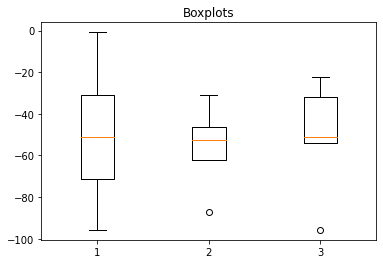

[array([-51.39433438, -77.31650521, -87.04276857,  -0.80469485,
       -30.97359255, -95.76037394, -51.31167123, -31.82844249,
       -53.91999374, -22.12549424]), array([-87.04276857, -30.97359255, -51.31167123, -53.91999374]), array([-95.76037394, -51.31167123, -31.82844249, -53.91999374,
       -22.12549424])]


In [ ]:
# Pour vous aider, la cellule qui suit contient un exemple pour tracer des *boxplot* à partir de jeu de données différents.
# exemple adapté de: https://matplotlib.org/3.3.3/gallery/pyplots/boxplot_demo_pyplot.html#sphx-glr-gallery-pyplots-boxplot-demo-pyplot-py

# Fixing random state for reproducibility
np.random.seed(14)

data = np.random.rand(10) * -100
data = [data, data[2::2], data[5::]]  # utilise le même ensemble de donnée pour construire 3 listes de données différentes
fig, ax = plt.subplots()
ax.set_title('Boxplots')
ax.boxplot(data)

plt.show()

print (data)

*votre réponse*